In [ ]:
from google.colab import drive

# Google Driveをマウント
drive.mount('/content/drive')

# マウント完了後のメッセージ
print("Google Driveがマウントされました！")

# lightgbmでトレーニングする

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score, precision_recall_curve


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# LightGBMパラメータ（学習率を下げる）
params = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'learning_rate': 0.1,  # 学習率を下げる
    'num_leaves': 31,
    'max_depth': 8,
    'verbose': -1
}

# クロスバリデーションの設定
n_splits = 5  # 分割数
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

f1_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # トレーニングデータと検証データの分割
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # データセットの作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
    valid_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns, reference=train_data)

    # モデルの学習
    model = lgb.train(
        params,
        train_data,
        valid_sets=[valid_data],
        num_boost_round=5000,  # イテレーション数を増やす
        callbacks=[lgb.early_stopping(150), lgb.log_evaluation(50)]
    )

    # 検証データの予測確率
    y_val_proba = model.predict(X_val)

    # 最適な閾値を計算
    precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)
    f1_fold = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
    best_threshold = thresholds[f1_fold.index(max(f1_fold))]
    print(f"Best Threshold: {best_threshold}")

    # 最適な閾値で評価
    y_val_pred = (y_val_proba > best_threshold).astype(int)
    f1 = f1_score(y_val, y_val_pred)
    f1_scores.append(f1)

    print(f"Fold {fold + 1} F1 Score: {f1}")

# 平均F1スコア
mean_f1 = sum(f1_scores) / len(f1_scores)
print(f"\nMean F1 Score across folds: {mean_f1}")


# モデルを保存
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_5.txt'
model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")



# 最適な閾値を決定する

In [ ]:
# 全ての検証データで予測
y_val_proba = model.predict(X_val)  # X_valはすべての検証データ
precision, recall, thresholds = precision_recall_curve(y_val, y_val_proba)

# 最適F1スコアの閾値
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]
best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Best Threshold (overall validation): {best_threshold}")


Best Threshold (overall validation): 0.19726323890446196


In [ ]:
!pip install optuna

# optunaで最適なパラメータを探す

In [ ]:
import pandas as pd
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
from sklearn.model_selection import StratifiedKFold
import optuna

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_3.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# クロスバリデーションの設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Optunaによるハイパーパラメータ探索の設定
def objective(trial):
    # ハイパーパラメータを探索
    params = {
        'objective': 'binary',
        'metric': 'binary_logloss',
        'boosting_type': 'gbdt',
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
        'num_leaves': trial.suggest_int('num_leaves', 31, 256),
        'max_depth': trial.suggest_int('max_depth', -1, 16),
        'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 10, 100),
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'feature_fraction': trial.suggest_uniform('feature_fraction', 0.7, 1.0),
        'bagging_fraction': trial.suggest_uniform('bagging_fraction', 0.7, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 10),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 1, 10),
        'verbose': -1
    }

    # クロスバリデーションで最適なイテレーションを計算
    iterations = []
    for train_idx, valid_idx in skf.split(X, y):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
        valid_data = lgb.Dataset(X_valid, label=y_valid, categorical_feature=categorical_columns)

        model = lgb.train(
            params,
            train_data,
            valid_sets=[valid_data],
            num_boost_round=1000,
            callbacks=[
                early_stopping(stopping_rounds=50),
                log_evaluation(50)
            ]
        )

        iterations.append(model.best_iteration)

    # 最適なブースト回数の平均を返す
    return sum(iterations) / len(iterations)

# Optunaで最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 最適なハイパーパラメータを表示
print("Best parameters:", study.best_params)

# 最適なパラメータで再トレーニング
best_params = study.best_params
best_params['objective'] = 'binary'
best_params['metric'] = 'binary_logloss'
best_params['boosting_type'] = 'gbdt'
best_params['verbose'] = -1

# 最適なイテレーション数を取得
best_num_boost_round = int(study.best_value)

# 全データでモデルをトレーニング
train_data = lgb.Dataset(X, label=y, categorical_feature=categorical_columns)
final_model = lgb.train(best_params, train_data, num_boost_round=best_num_boost_round)



# 最適なパラメータでモデルをトレーニングする

In [ ]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.model_selection import StratifiedKFold

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_3.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 最適なパラメータ
best_params = {
    'learning_rate': 0.012528262312852314,
    'num_leaves': 154,
    'max_depth': 2,
    'min_data_in_leaf': 91,
    'lambda_l1': 3.7686025319987305e-08,
    'lambda_l2': 0.23010952486313951,
    'feature_fraction': 0.9527151400808356,
    'bagging_fraction': 0.9322382366626687,
    'bagging_freq': 8,
    'scale_pos_weight': 1.0421558155965245,
    'objective': 'binary',
    'metric': 'binary_logloss',
    'verbosity': -1,
    'seed': 42
}

# クロスバリデーションの設定
n_splits = 5
kf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# 結果を格納するリスト
f1_scores_list = []
iterations = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X, y)):
    print(f"Fold {fold + 1}/{n_splits}")

    # 学習データと検証データの分割
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # LightGBM用データセットの作成
    train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_columns)
    val_data = lgb.Dataset(X_val, label=y_val, categorical_feature=categorical_columns)

    # モデルのトレーニング
    model = lgb.train(
        best_params,
        train_data,
        num_boost_round=1000,
        valid_sets=[train_data, val_data],
        valid_names=['train', 'valid'],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50),
            lgb.log_evaluation(50)
        ]
    )

    # 最良のイテレーションを記録
    iterations.append(model.best_iteration)

    # 検証データでの予測確率
    y_val_proba = model.predict(X_val, num_iteration=model.best_iteration)

    # Precision-Recall Curveを計算
    precisions, recalls, thresholds = precision_recall_curve(y_val, y_val_proba)

    # F1スコアを計算
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls)
    f1_scores = np.nan_to_num(f1_scores)  # NaNを防止

    # 最適な閾値を見つける
    optimal_threshold = thresholds[np.argmax(f1_scores)]
    print(f"Optimal Threshold for Fold {fold + 1}: {optimal_threshold}")

    # 最適な閾値で予測を調整
    y_val_adjusted = (y_val_proba >= optimal_threshold).astype(int)

    # 最終的なF1スコア
    final_f1_score = f1_score(y_val, y_val_adjusted)
    print(f"Final F1 Score for Fold {fold + 1}: {final_f1_score}")

    # スコアをリストに追加
    f1_scores_list.append(final_f1_score)

# 平均F1スコアを計算
mean_f1_score = np.mean(f1_scores_list)
print(f"Mean F1 Score across all folds: {mean_f1_score}")

# モデルを保存
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_3.txt'
final_model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")


# モデルが重視する特徴量を可視化する

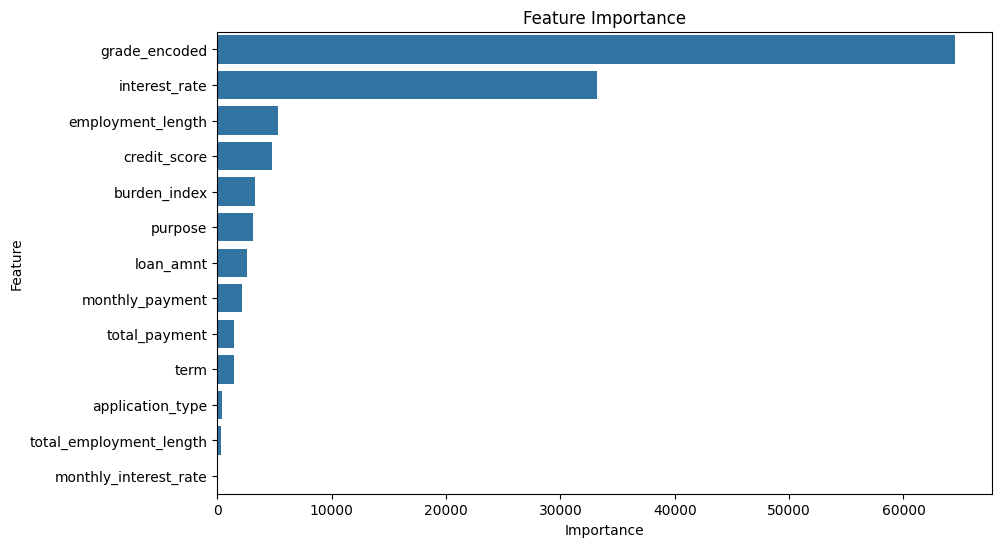

                    Feature    Importance
7             grade_encoded  64536.610383
2             interest_rate  33192.379066
3         employment_length   5347.987510
5              credit_score   4806.120086
11             burden_index   3270.202911
4                   purpose   3113.614519
0                 loan_amnt   2568.770869
9           monthly_payment   2167.455474
10            total_payment   1452.596882
1                      term   1448.073074
6          application_type    404.925931
12  total_employment_length    348.930061
8     monthly_interest_rate      0.000000


In [ ]:
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_4.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# モデルのトレーニング（例としてLightGBMを仮定）
train_data = lgb.Dataset(X, label=y)
final_model = lgb.train({'objective': 'binary'}, train_data, num_boost_round=100)

# 特徴量重要度を取得
feature_importances = final_model.feature_importance(importance_type='gain')  # 'split' も選択可能
feature_names = final_model.feature_name()

# データフレームとして整理
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 特徴量重要度の可視化
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.show()

# 特徴量重要度を確認
print(importance_df)


# 実際のtestデータで予測する

In [ ]:
import pandas as pd
import lightgbm as lgb

# ファイルパス
test_file_path = '/content/drive/My Drive/signate/test_1221_5.csv'
model_file_path = '/content/drive/My Drive/signate/lgbm_model_1221_5.txt'

# テストデータの読み込み
test_df = pd.read_csv(test_file_path, low_memory=False)


# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id', 'grade', 'term_months'], errors='ignore')  # 除外列をトレーニングデータと一致

# 保存したモデルを読み込む
final_model = lgb.Booster(model_file=model_file_path)

# テストデータの予測確率を取得
test_proba = final_model.predict(X_test)  # クラス1の確率を取得

# 最適閾値を設定
optimal_threshold =  0.19726323890446196  # トレーニングで計算した最適閾値を使用
test_predictions = (test_proba > optimal_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': test_predictions  # 予測結果
})

# CSVとして保存
submission_file_path = '/content/drive/My Drive/signate/submission1221_4.csv'
submission.to_csv(submission_file_path, index=False, header=False)  # ヘッダーを削除
print(f"Submission file saved to: {submission_file_path}")


In [ ]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1221_4.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)

# catboostでトレーニングする

In [ ]:
!pip install catboost

# optunaで最適なパラメータを探す

In [ ]:
import optuna
import pandas as pd
import numpy as np
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_curve, f1_score

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 欠損値の確認と処理
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider handling them explicitly.")

# Optunaの目的関数
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 300, 3000),
        'depth': trial.suggest_int('depth', 10, 16),
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.2, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1, 15),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0, 10),
        'random_strength': trial.suggest_float('random_strength', 0, 10),
        'eval_metric': 'F1',
        'use_best_model': True,
        'random_seed': 42,
        'verbose': 0
    }

    # Stratified K-Fold Cross Validation
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []

    for train_idx, val_idx in skf.split(X, y):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 欠損値の処理
        train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
        val_pool = Pool(X_val, y_val, cat_features=categorical_columns)

        # モデルのトレーニング
        model = CatBoostClassifier(**params)
        model.fit(train_pool, eval_set=val_pool, early_stopping_rounds=100, verbose=0)

        # 閾値調整
        y_pred_prob = model.predict_proba(X_val)[:, 1]
        precision, recall, thresholds = precision_recall_curve(y_val, y_pred_prob)

        # F1スコア計算の安定化
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores = np.nan_to_num(f1_scores)  # NaNを0に変換
        if len(thresholds) == 0:  # 念のためのエッジケース対応
            continue
        best_threshold = thresholds[np.argmax(f1_scores)]

        # 最適閾値で予測
        y_pred_adjusted = (y_pred_prob >= best_threshold).astype(int)
        scores.append(f1_score(y_val, y_pred_adjusted))

    # 平均F1スコアを返す
    return np.mean(scores) if len(scores) > 0 else 0

# Optunaの最適化
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

# 最適パラメータの確認
print("Best params:", study.best_params)
print("Best F1 score:", study.best_value)


# 最適なパラメータでトレーニングする

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_curve, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool


# データ読み込み
file_path = '/content/drive/My Drive/signate/train_1221_5.csv'
df = pd.read_csv(file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status', 'grade', 'term_months'])
y = df['loan_status']

# 欠損値の確認と処理
if X.isnull().sum().sum() > 0:
    print("Warning: Missing values found in features. Consider handling them explicitly.")

# トレーニングデータと検証データに分割
X_train, X_eval, y_train, y_eval = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Poolオブジェクトを作成
train_pool = Pool(X_train, y_train, cat_features=categorical_columns)
eval_pool = Pool(X_eval, y_eval, cat_features=categorical_columns)

# 最適パラメータを設定
best_params = {
    'iterations': 531,
    'depth': 11,
    'learning_rate': 0.06382731423716013,
    'l2_leaf_reg': 8.96608380944381,
    'border_count': 102,
    'bagging_temperature': 4.092390774597465,
    'random_strength': 2.298108915615952,
    'eval_metric': 'F1',
    'use_best_model': True,
    'random_seed': 42
}

# モデルのトレーニング
final_model = CatBoostClassifier(**best_params)
final_model.fit(train_pool, eval_set=eval_pool, early_stopping_rounds=100, verbose=50)

# 検証データで予測確率を取得
eval_proba = final_model.predict_proba(eval_pool)[:, 1]  # クラス1の確率を取得

# Precision-Recall Curve を使用して最適な閾値を計算
precision, recall, thresholds = precision_recall_curve(y_eval, eval_proba)

# F1スコアの計算
f1_scores = 2 * (precision * recall) / (precision + recall)
f1_scores = np.nan_to_num(f1_scores)  # NaNを0に変換

# 最適な閾値
optimal_threshold = thresholds[np.argmax(f1_scores)]
print(f"Optimal Threshold: {optimal_threshold}")

# 最適な閾値でF1スコアを計算
y_pred_adjusted = (eval_proba >= optimal_threshold).astype(int)
final_f1_score = f1_score(y_eval, y_pred_adjusted)
print(f"Final F1 Score with Optimal Threshold: {final_f1_score}")

# モデルを保存
model_file_path = '/content/drive/My Drive/signate/catboost_model_1221_1.cbm'
final_model.save_model(model_file_path)
print(f"Model saved to: {model_file_path}")


# 実際のテストデータで予測する

In [ ]:
import pandas as pd
from catboost import CatBoostClassifier, Pool

# ファイルパス
test_file_path = '/content/drive/My Drive/signate/test_1221_5.csv'
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1221_1.cbm'

# テストデータの読み込み
test_df = pd.read_csv(test_file_path, low_memory=False)

# カテゴリカル列
categorical_columns = ['purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id', 'grade', 'term_months'], errors='ignore')  # 除外列をトレーニングデータと一致

# Poolオブジェクトを作成
test_pool = Pool(X_test, cat_features=categorical_columns)

# 保存したモデルを読み込む
final_model = CatBoostClassifier()
final_model.load_model(model_file_path)

# テストデータの予測確率を取得
test_proba = final_model.predict_proba(test_pool)[:, 1]  # クラス1の確率を取得

# 最適閾値を設定
optimal_threshold = 0.21294587588263655  # トレーニングで計算した最適閾値を使用
test_predictions = (test_proba > optimal_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': test_predictions  # 予測結果
})

# CSVとして保存
submission_file_path = '/content/drive/My Drive/signate/submission1221_7.csv'
submission.to_csv(submission_file_path, index=False, header=False)  # ヘッダーを削除
print(f"Submission file saved to: {submission_file_path}")


Submission file saved to: /content/drive/My Drive/signate/submission1221_7.csv


In [ ]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1221_7.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)

# アンサンブルモデルを作成する

In [ ]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_recall_curve
from catboost import CatBoostClassifier

# データ読み込み
file_path = '/content/drive/My Drive/signate/train_with_features.csv'
df = pd.read_csv(file_path, low_memory=False)

# LightGBMモデルを読み込む
lgbm_model_file_path = '/content/drive/My Drive/signate/lgbm_model_1219_2.txt'
lgbm_model = lgb.Booster(model_file=lgbm_model_file_path)

# CatBoostモデルを読み込む
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1219_1.cbm'
cat_model = CatBoostClassifier()
cat_model.load_model(cat_model_file_path)

# カテゴリカル列
categorical_columns = ['grade', 'purpose', 'application_type']
for col in categorical_columns:
    df[col] = df[col].astype('category')

# 特徴量とターゲット
X = df.drop(columns=['loan_status'])
y = df['loan_status']

# データ分割
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# カテゴリカル型が保持されているか確認
print(X_val.dtypes)

# LightGBMの予測確率
lgbm_preds = lgbm_model.predict(X_val)

# CatBoostの予測確率
cat_preds = cat_model.predict_proba(X_val)[:, 1]  # クラス1の確率

# アンサンブル
lgbm_weight = 0.5
cat_weight = 0.5
ensemble_preds = lgbm_weight * lgbm_preds + cat_weight * cat_preds

# Precision-Recall Curveを使って最適な閾値を計算
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_preds)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

if len(thresholds) > 0:
    best_threshold = thresholds[f1_scores.index(max(f1_scores))]
else:
    best_threshold = 0.5  # デフォルト閾値

# 最終予測
final_preds = (ensemble_preds > best_threshold).astype(int)

# F1スコアの評価
ensemble_f1 = f1_score(y_val, final_preds)
print(f"Ensemble Model F1 Score: {ensemble_f1}")


loan_amnt                 float64
term                      float64
interest_rate             float64
grade                    category
employment_length         float64
purpose                  category
credit_score              float64
application_type         category
monthly_interest_rate     float64
term_months               float64
monthly_payment           float64
total_payment             float64
burden_index              float64
dtype: object
Ensemble Model F1 Score: 0.4350337532187348


Best Threshold: 0.21791771931677495
Best F1 Score: 0.43507306889352815


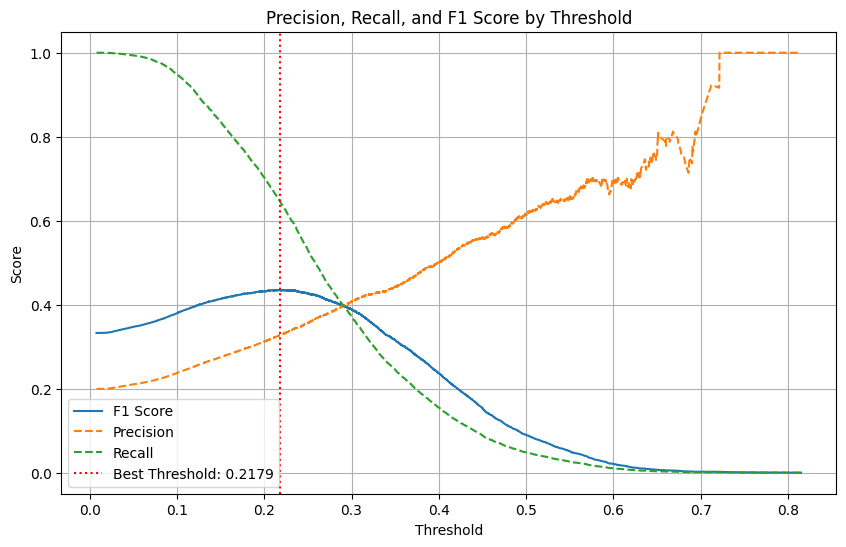

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Precision-Recall Curveを計算
precision, recall, thresholds = precision_recall_curve(y_val, ensemble_preds)

# F1スコアを計算
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# 最適な閾値を取得
best_threshold = thresholds[np.argmax(f1_scores)]
best_f1_score = max(f1_scores)

# 結果を出力
print(f"Best Threshold: {best_threshold}")
print(f"Best F1 Score: {best_f1_score}")

# グラフで可視化
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores[:-1], label='F1 Score')  # 最後のスコアに対応する閾値はない
plt.plot(thresholds, precision[:-1], label='Precision', linestyle='--')
plt.plot(thresholds, recall[:-1], label='Recall', linestyle='--')
plt.axvline(best_threshold, color='r', linestyle=':', label=f'Best Threshold: {best_threshold:.4f}')
plt.title('Precision, Recall, and F1 Score by Threshold')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.grid()
plt.show()


In [ ]:
from sklearn.metrics import precision_recall_curve

# 検証データで予測
val_preds = ensemble_preds   # アンサンブルモデルの検証データ予測結果

# Precision-Recall Curveを計算
precision, recall, thresholds = precision_recall_curve(y_val, val_preds)
f1_scores = [2 * (p * r) / (p + r) if (p + r) > 0 else 0 for p, r in zip(precision, recall)]

# F1スコアが最大となる閾値を選択
best_threshold = thresholds[f1_scores.index(max(f1_scores))]
print(f"Optimal Threshold from Validation Data: {best_threshold}")


Optimal Threshold from Validation Data: 0.21791771931677495


In [ ]:
# LightGBMモデルを読み込む
lgbm_model_file_path = '/content/drive/My Drive/signate/lgbm_model_1219_2.txt'
lgbm_model = lgb.Booster(model_file=lgbm_model_file_path)

# CatBoostモデルを読み込む
cat_model_file_path = '/content/drive/My Drive/signate/catboost_model_1219_1.cbm'
cat_model = CatBoostClassifier()
cat_model.load_model(cat_model_file_path)

# テストデータの読み込み
test_file_path = '/content/drive/My Drive/signate/test_with_features.csv'
test_df = pd.read_csv(test_file_path, low_memory=False)

# カテゴリカル列の型変換
categorical_columns = ['grade', 'purpose', 'application_type']
for col in categorical_columns:
    test_df[col] = test_df[col].astype('category')

# 特徴量を抽出
X_test = test_df.drop(columns=['id'])  # 必要に応じて除外する列を調整

# LightGBMとCatBoostの予測確率
lgbm_preds_test = lgbm_model.predict(X_test)
cat_preds_test = cat_model.predict_proba(X_test)[:, 1]

# アンサンブル
lgbm_weight = 0.5
cat_weight = 0.5
ensemble_preds_test = lgbm_weight * lgbm_preds_test + cat_weight * cat_preds_test

# 最適閾値でクラス予測
best_threshold = 0.217
final_test_preds = (ensemble_preds_test > best_threshold).astype(int)

# 提出用のデータフレーム作成
submission = pd.DataFrame({
    'id': test_df['id'],  # テストデータのID列
    'loan_status': final_test_preds  # 予測結果
})

# 結果の保存
output_file_path = '/content/drive/My Drive/signate/submission1219_7.csv'
submission.to_csv(output_file_path, index=False, header=False)

print(f"Predictions saved to: {output_file_path}")


Predictions saved to: /content/drive/My Drive/signate/submission1219_7.csv


In [ ]:
import pandas as pd

# CSVファイルを読み込む
file_path = '/content/drive/My Drive/signate/submission1219_7.csv'
test_df = pd.read_csv(file_path, low_memory=False)

test_df.head(30)